<a href="https://colab.research.google.com/github/B34R-e/Basic-Deep-Learning/blob/main/Image_Retrieval_with_ViT_(pretrained_Vision_Transformer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#

In [ ]:
!unzip /content/drive/MyDrive/image_retrieval_dataset.zip

**1. Import necessary libraries.**

In [1]:
!pip install transformers==4.31.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor , ViTForImageClassification

**2. Read the data.**

In [4]:
dataset_dir = '/content/images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
src_images = []
for filename in image_filenames:
  filepath = os.path.join(
      dataset_dir, filename
  )

  image = cv2.imread(filepath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  src_images.append(image)

**3. Declare ViT model.**

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224') # for normalizing input images
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device) # declare the model

**4. Preprocessing Function.**

In [8]:
def preprocessing(images):
  inputs = processor(
      images,
      return_tensors = 'pt'
  ).to(device)

  with torch.no_grad():                                     # Extract the features
    output = model(
        **inputs,
        output_hidden_states = True,
    ).hidden_states[-1][:, 0, :].detach().cpu().numpy()

  return output # features extracted

In [9]:
preprocessed_src_images = preprocessing(src_images)

**5. Similarity Computing Function.**

In [10]:
def cosine_similarity(query_vector, src_vectors):
  query_norm = np.linalg.norm(query_vector)
  normalized_query = query_vector / query_norm

  src_norms = np.linalg.norm(src_vectors, axis=1)
  normalized_src = src_vectors / src_norms[:, np.newaxis]

  cosine_similarity = np.dot(normalized_src, normalized_query)

  return cosine_similarity

**6. Ranking Function.**

In [11]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
  scores = cosine_similarity(
      preprocessed_query_image,
      preprocessed_src_images
  )

  ranked_list = np.argsort(scores)[::-1][:top_k]
  scores = scores[ranked_list]

  return ranked_list, scores

**7. Query Testing.**

Query Image


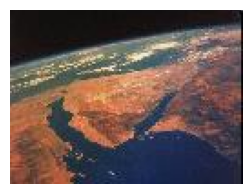

Top 10 results


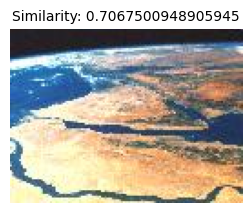

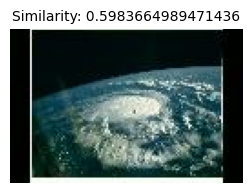

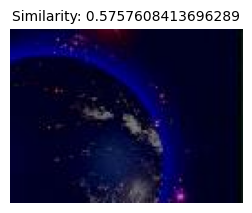

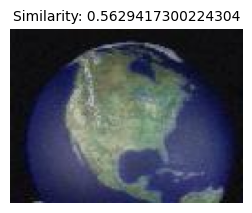

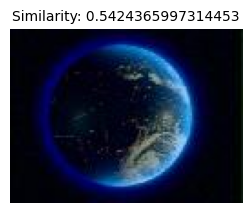

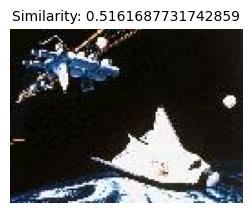

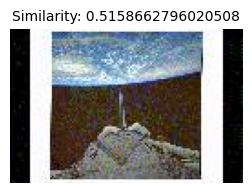

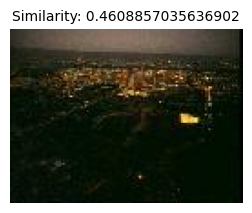

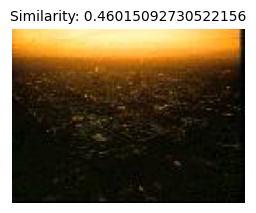

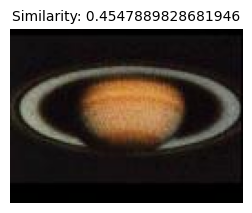

In [13]:
query_image_paths = [
    '/content/images_mr/615.jpg'
]
top_k = 10

for query_image_path in query_image_paths:
  query_image = cv2.imread(query_image_path, 1)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
  preprocessed_query_image = preprocessing(query_image).squeeze(0)

  ranked_list, scores = ranking(
      preprocessed_query_image,
      preprocessed_src_images,
      top_k
  )

  print('Query Image')
  plt.figure(figsize=(3,3))
  plt.imshow(query_image)
  plt.axis('off')
  plt.show()
  print(f'Top {top_k} results')
  for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3,3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f'Similarity: {similarity_score}', fontsize=10)
    plt.axis('off')
    plt.show()